In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
import seaborn as sns
from tensorflow import keras
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

In [2]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [3]:
df = pd.read_csv("prediction_dataset.csv",index_col=0)
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['wind_dir']]).toarray())
new_names = dict()
for index,x in enumerate(enc.get_feature_names(['wind_dir'])):
    new_names[index] = x

df = df.join(enc_df)
df = df.rename(columns=new_names)

enc_df = pd.DataFrame(enc.fit_transform(df[['clouds']]).toarray())
new_names = dict()
for index,x in enumerate(enc.get_feature_names(['clouds'])):
    new_names[index] = x
df = df.join(enc_df)
df = df.rename(columns=new_names)

df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M")

# Extracting the hour of day
df['hour'] = [x.hour for x in df['time']]
# Extracting the hour of day
df['day'] = [x.day for x in df['time']]

# Extracting the month of the year 
df['month'] = [x.month for x in df['time']]

# Creating the cyclical daily feature 
df['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in df['hour']]
df['day_sin'] = [np.sin(x * (2 * np.pi / 24)) for x in df['hour']]

# Extracting the timestamp from the datetime object 
df['timestamp'] = [x.timestamp() for x in df['time']]

# Seconds in day 
s = 24 * 60 * 60 

# Seconds in year 
year = (365.25) * s

df['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in df['timestamp']]
df['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in df['timestamp']]

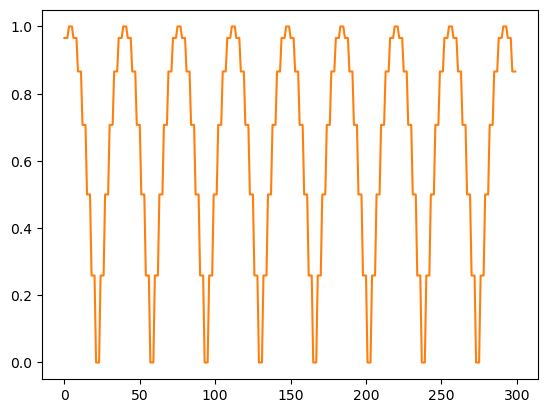

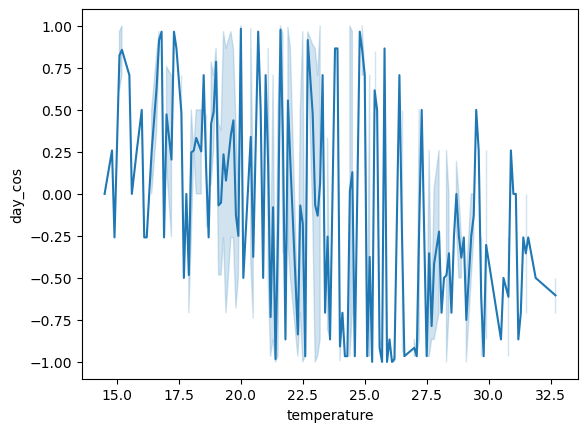

In [59]:
abs(df['day_cos'][:300]).plot()
plt.show()
sns.lineplot(x='temperature', y='day_cos', data=df[:300])
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4597 entries, 0 to 4596
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time                     4597 non-null   datetime64[ns]
 1   station                  4597 non-null   object        
 2   temperature              4597 non-null   float64       
 3   wind_dir                 4597 non-null   object        
 4   wind_speed               4597 non-null   float64       
 5   wind_impact              4597 non-null   float64       
 6   clouds                   4597 non-null   object        
 7   weather                  4597 non-null   object        
 8   wind_dir_BEZV            4597 non-null   float64       
 9   wind_dir_J               4597 non-null   float64       
 10  wind_dir_JV              4597 non-null   float64       
 11  wind_dir_JZ              4597 non-null   float64       
 12  wind_dir_PREM            4597 non-

In [5]:
df.head()

,time,station,temperature,wind_dir,wind_speed,wind_impact,clouds,weather,wind_dir_BEZV,wind_dir_J,...,clouds_Takmer zamračené,clouds_Zamračené,hour,day,month,day_cos,day_sin,timestamp,month_cos,month_sin
0,2021-07-29 11:00:00,Bratislava - Mlynská Dolina,24.3,SZ,1.0,0.0,Takmer jasno,pekne,0.0,0.0,...,0.0,0.0,11,29,7,-0.965926,2.588190e-01,1.627556e+09,-0.893418,-0.449226
1,2021-07-29 11:00:00,Bratislava Ivanka,24.4,SZ,4.0,0.0,Takmer jasno,pekne,0.0,0.0,...,0.0,0.0,11,29,7,-0.965926,2.588190e-01,1.627556e+09,-0.893418,-0.449226
2,2021-07-29 11:00:00,Bratislava Koliba,24.2,PREM,2.0,0.0,Takmer jasno,pekne,0.0,0.0,...,0.0,0.0,11,29,7,-0.965926,2.588190e-01,1.627556e+09,-0.893418,-0.449226
3,2021-07-29 12:00:00,Bratislava - Mlynská Dolina,25.3,Z,2.0,0.0,Takmer jasno,pekne,0.0,0.0,...,0.0,0.0,12,29,7,-1.000000,1.224647e-16,1.627560e+09,-0.893096,-0.449866
4,2021-07-29 12:00:00,Bratislava Ivanka,25.9,Z,3.0,0.0,Malá oblačnosť,pekne,0.0,0.0,...,0.0,0.0,12,29,7,-1.000000,1.224647e-16,1.627560e+09,-0.893096,-0.449866


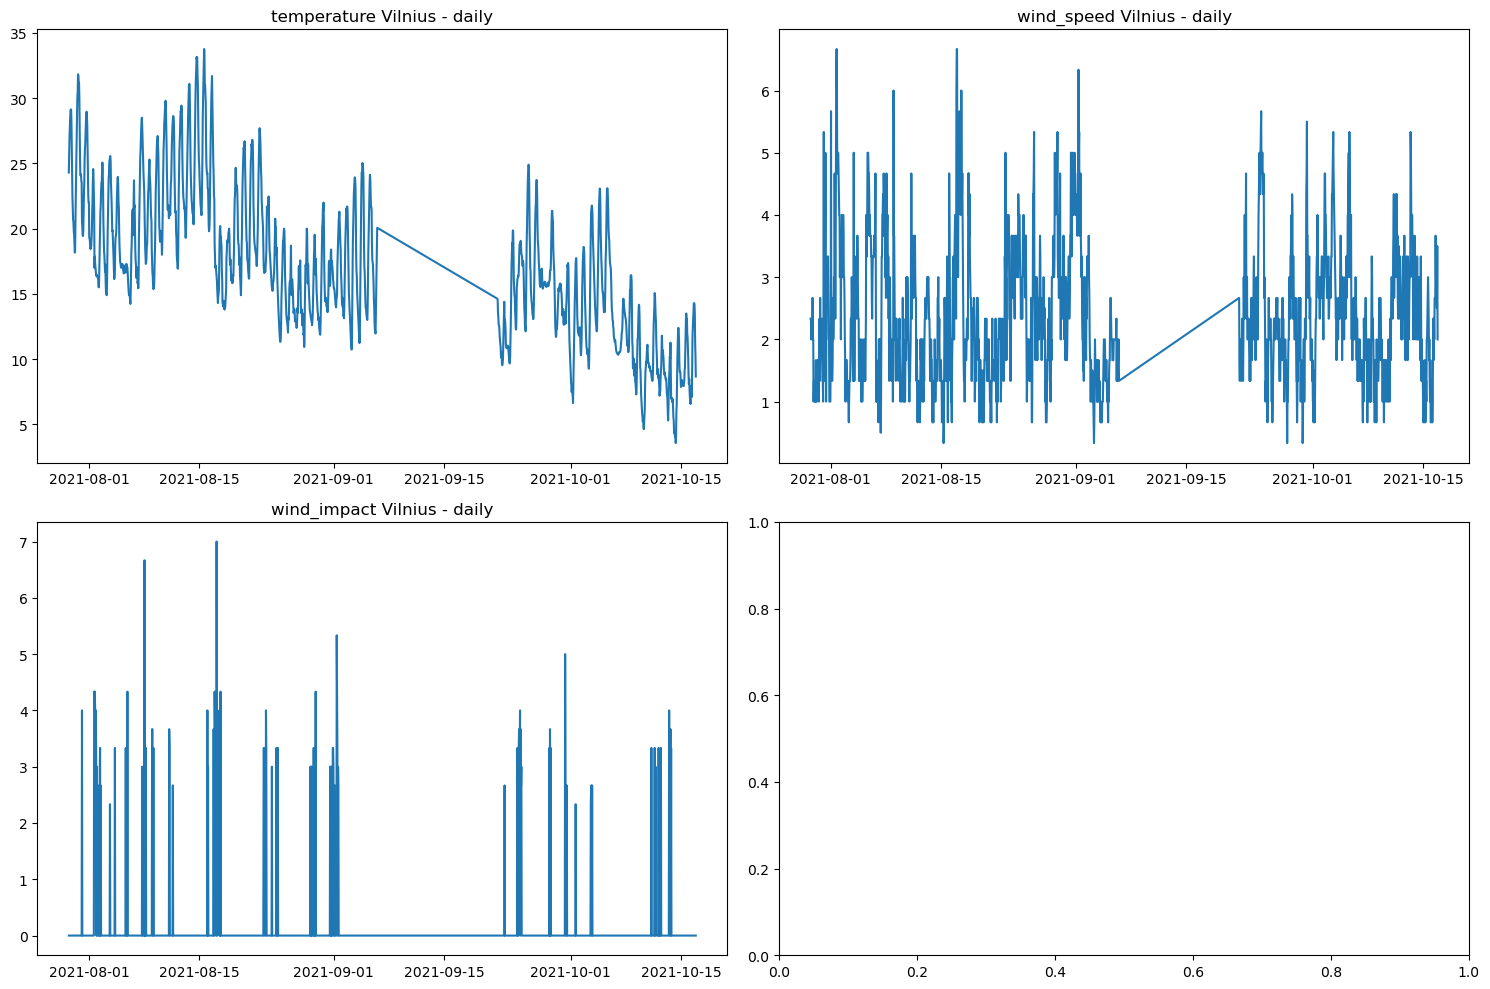

In [6]:
features = ["temperature", "wind_speed", "wind_impact"]
plot_features = df.groupby('time')[features].mean()

fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} Vilnius - daily')
        
plt.tight_layout()

plt.show()

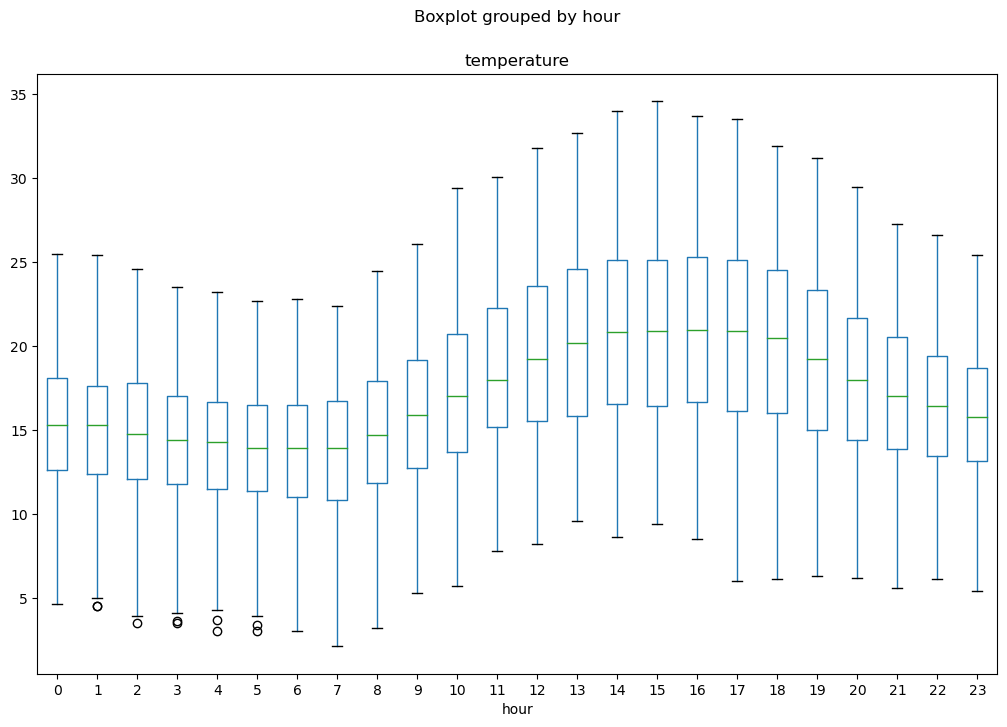

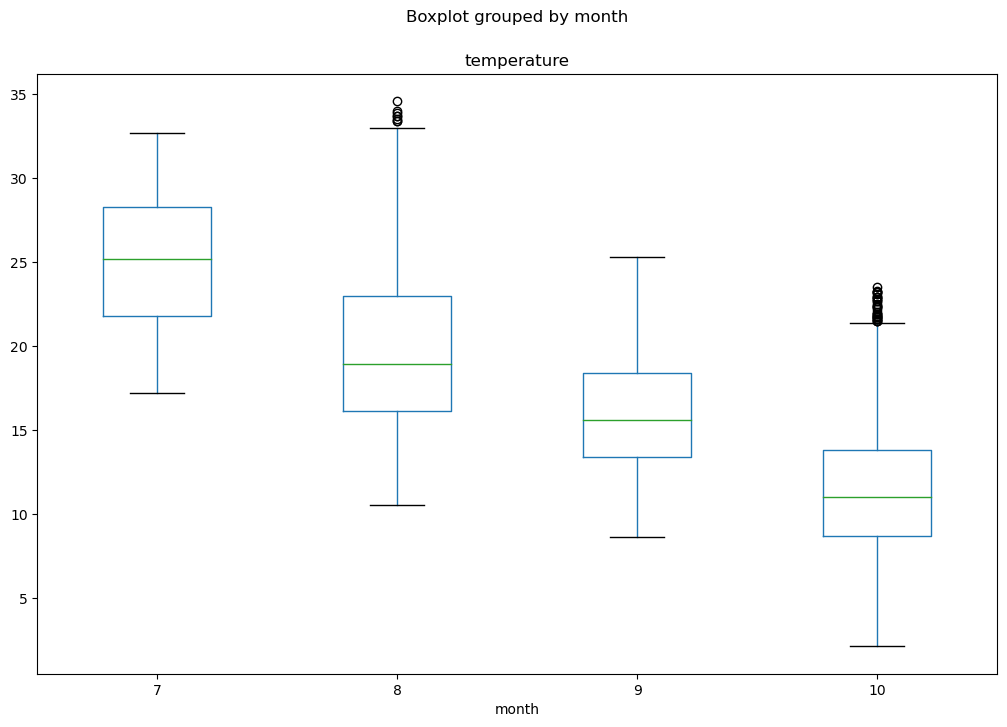

In [7]:
df.boxplot('temperature', by='hour', figsize=(12, 8), grid=False)
plt.show()
df.boxplot('temperature', by='month', figsize=(12, 8), grid=False)
plt.show()

In [35]:
# Number of lags (hours back) to use for models
lag = 64

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 100

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 20

# The features used in the modeling 
features_final = [ 'temperature','wind_speed',
       'wind_impact', 'wind_dir_BEZV', 'wind_dir_J',
       'wind_dir_JV', 'wind_dir_JZ', 'wind_dir_PREM', 'wind_dir_S',
       'wind_dir_SV', 'wind_dir_SZ', 'wind_dir_V', 'wind_dir_Z',
       'clouds_Jasno', 'clouds_Malá oblačnosť', 'clouds_Oblačno',
       'clouds_Polooblačno', 'clouds_Takmer jasno', 'clouds_Takmer zamračené',
       'clouds_Zamračené','day_cos', 'day_sin', 'month_sin', 'month_cos']

In [9]:
df[features_final].head(10)

,temperature,wind_speed,wind_impact,wind_dir_BEZV,wind_dir_J,wind_dir_JV,wind_dir_JZ,wind_dir_PREM,wind_dir_S,wind_dir_SV,...,clouds_Malá oblačnosť,clouds_Oblačno,clouds_Polooblačno,clouds_Takmer jasno,clouds_Takmer zamračené,clouds_Zamračené,day_cos,day_sin,month_sin,month_cos
0,24.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.965926,2.588190e-01,-0.449226,-0.893418
1,24.4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.965926,2.588190e-01,-0.449226,-0.893418
2,24.2,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.965926,2.588190e-01,-0.449226,-0.893418
3,25.3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-1.000000,1.224647e-16,-0.449866,-0.893096
4,25.9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.224647e-16,-0.449866,-0.893096
5,25.7,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-1.000000,1.224647e-16,-0.449866,-0.893096
6,26.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.965926,-2.588190e-01,-0.450506,-0.892773
7,27.1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-0.965926,-2.588190e-01,-0.450506,-0.892773
8,27.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.965926,-2.588190e-01,-0.450506,-0.892773
9,27.8,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-0.866025,-5.000000e-01,-0.451146,-0.892450


In [36]:
# Subseting only the needed columns 
ts = df[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]


print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (4078, 64, 24)
Shape of the target data: (4078, 1)
Shape of validation data: (454, 64, 24)
Shape of the validation target data: (454, 1)


In [37]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [39]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [40]:
history = model.train()

Epoch 1/100
8/8 [==============================] - 1s 76ms/step - loss: 0.9558 - val_loss: 1.7328
Epoch 2/100
8/8 [==============================] - 0s 59ms/step - loss: 0.8024 - val_loss: 1.4386
Epoch 3/100
8/8 [==============================] - 0s 48ms/step - loss: 0.6807 - val_loss: 1.0652
Epoch 4/100
8/8 [==============================] - 0s 46ms/step - loss: 0.5821 - val_loss: 0.6513
Epoch 5/100
8/8 [==============================] - 0s 49ms/step - loss: 0.5186 - val_loss: 0.5699
Epoch 6/100
8/8 [==============================] - 0s 47ms/step - loss: 0.4540 - val_loss: 0.6244
Epoch 7/100
8/8 [==============================] - 0s 47ms/step - loss: 0.4102 - val_loss: 0.5408
Epoch 8/100
8/8 [==============================] - 0s 47ms/step - loss: 0.3787 - val_loss: 0.4837
Epoch 9/100
8/8 [==============================] - 0s 50ms/step - loss: 0.3501 - val_loss: 0.4995
Epoch 10/100
8/8 [==============================] - 0s 47ms/step - loss: 0.3287 - val_loss: 0.4642
Epoch 11/100
8/8 [=

<ipython-input-41-e93286d91971>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
<ipython-input-41-e93286d91971>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')


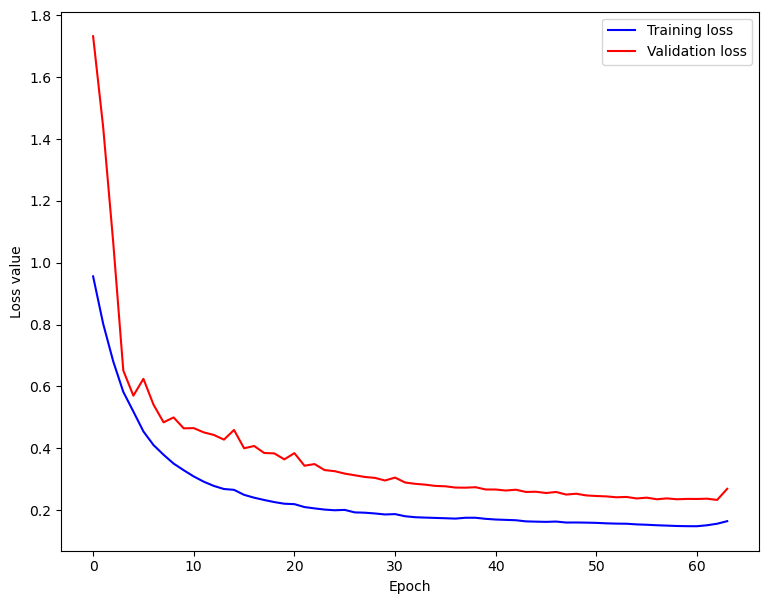

In [41]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

0.33165763487956756


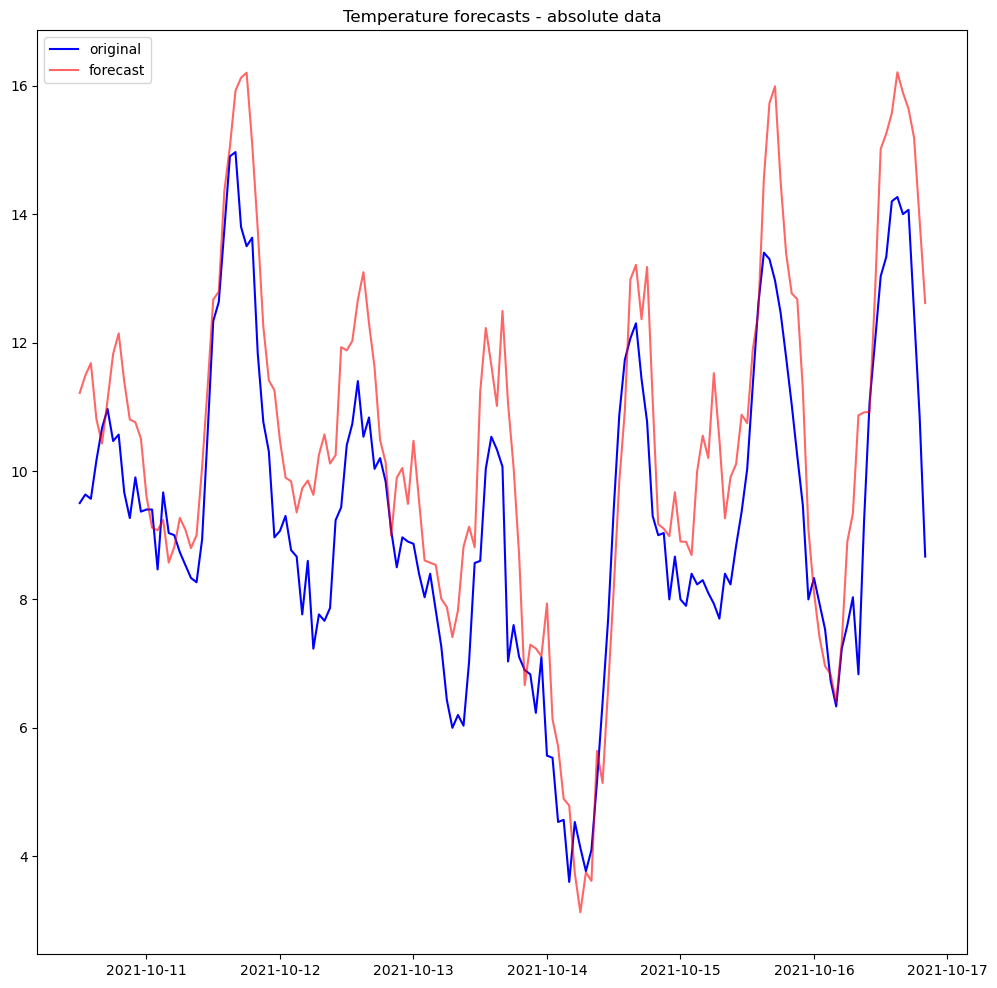

In [43]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

mse=mean_squared_error(Yval, yhat)
print(np.sqrt(mse))

# Creating the frame to store both predictions
days = df['time'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['temperature']) + train_mean['temperature'] for x in frame['temp']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()

In [30]:
X = [ 'wind_speed',
       'wind_impact', 'wind_dir_BEZV', 'wind_dir_J',
       'wind_dir_JV', 'wind_dir_JZ', 'wind_dir_PREM', 'wind_dir_S',
       'wind_dir_SV', 'wind_dir_SZ', 'wind_dir_V', 'wind_dir_Z',
       'clouds_Jasno', 'clouds_Malá oblačnosť', 'clouds_Oblačno',
       'clouds_Polooblačno', 'clouds_Takmer jasno', 'clouds_Takmer zamračené',
       'clouds_Zamračené','day_cos', 'day_sin', 'month_sin', 'month_cos']
y = 'temperature'
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.1,random_state=22)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [31]:
model = LinearRegression()
model.fit(X_train, y_train)
x = model.predict(X_test)
mse=mean_squared_error(y_test, x)
print(np.sqrt(mse))

3.062548074746056


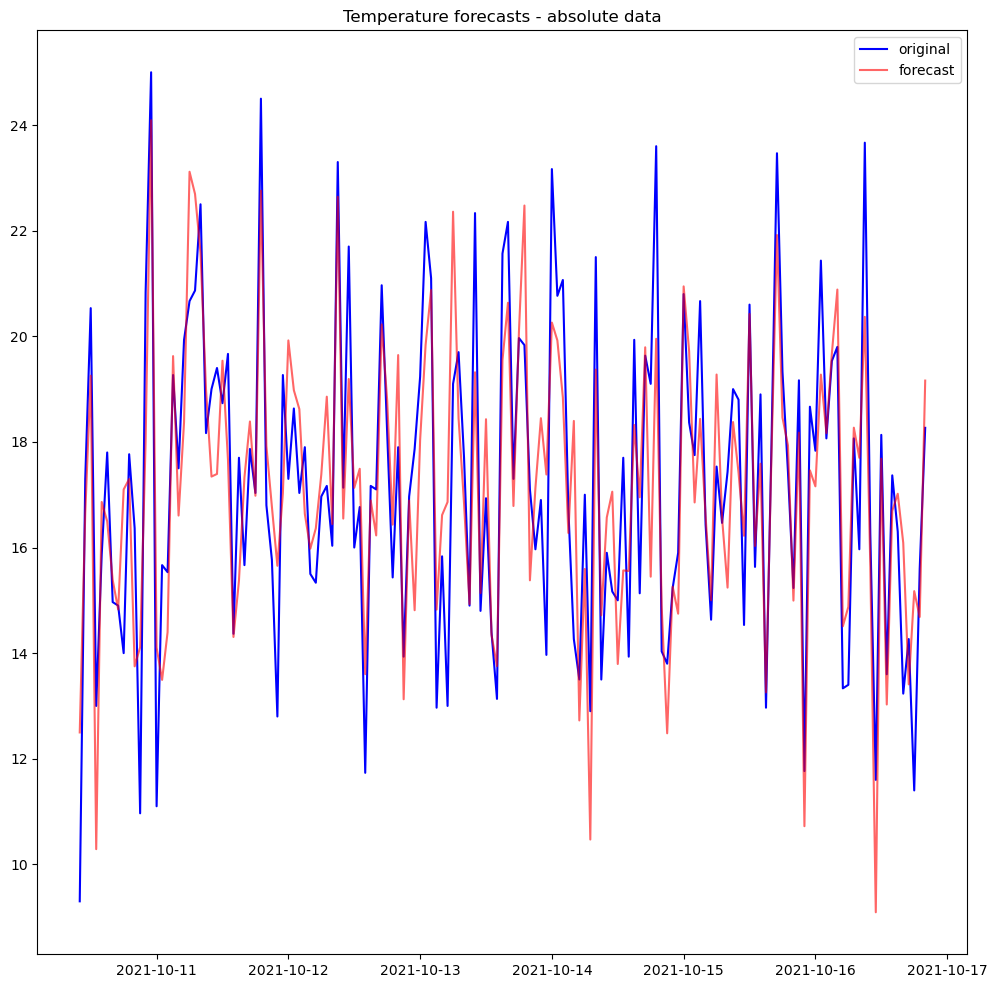

In [32]:
yhat = [x for x in model.predict(X_test)]
y = [y for y in y_test]

# Creating the frame to store both predictions
days = df['time'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = frame['temp']

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()

In [33]:
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=22)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))


0.7983865212498727


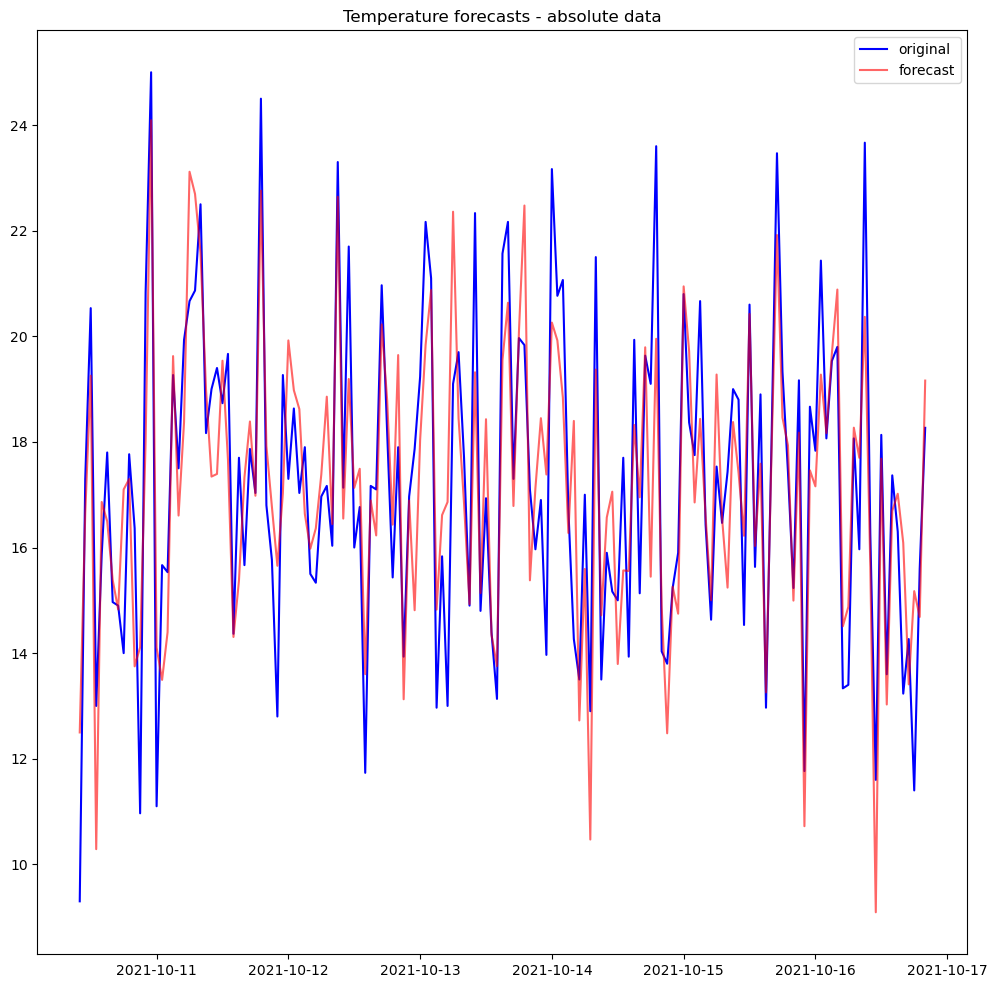

In [34]:
yhat = [x for x in model.predict(X_test)]
y = [y for y in y_test]

# Creating the frame to store both predictions
days = df['time'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = frame['temp']

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()